# Importing required libraries

In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import random
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
scaler = MinMaxScaler()

# Reading dataframe and checking for null values

In [55]:
df = pd.read_csv("C:/Users/sidha/Downloads/data_scientist_dataset/data_scientist_dataset.csv")
df.isna().sum()

Unnamed: 0                  0
ZoneDesc                    0
DistrictDesc                0
MSCFiscalYearMonth          0
SiteReferenceNumber         0
SiteSegmentation            0
CurrentTenure               0
ItemNumber                  0
ProductLineDesc             0
Sales                  206364
dtype: int64

# Filling Null values with random values

In [56]:
df.head(10)
df["Sales"].fillna(lambda x: random.choice(df[df["Sales"] != np.nan]["Sales"]), inplace =True)

# Grouping DataFrame by Months on Sales and plotting sales vs months

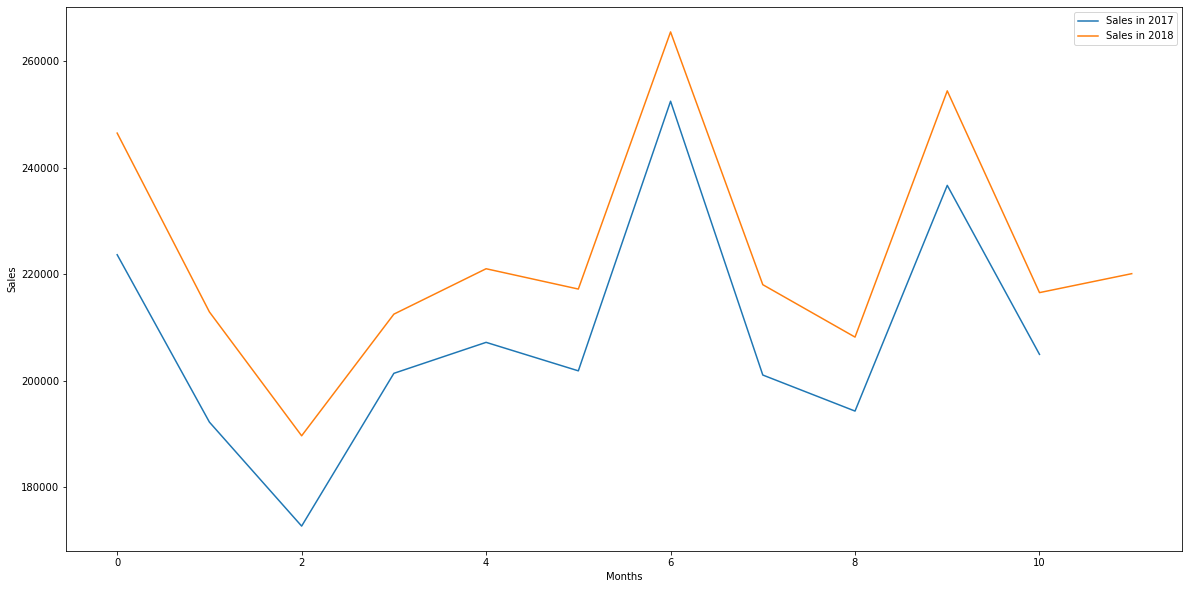

In [57]:
trend_df = df.groupby(['MSCFiscalYearMonth'], as_index=False).agg({"Sales": "count"})
arr = np.arange(12)
arr = list(arr)
arr = arr+arr
trend_df["Indices"] = arr
a4_dims = (20, 10)
fig, ax = plt.subplots(figsize=a4_dims)
plt.plot(trend_df["Indices"].iloc[0:11], trend_df["Sales"].iloc[0:11])
plt.plot(trend_df["Indices"].iloc[12:], trend_df["Sales"].iloc[12:])
plt.xlabel('Months')
plt.ylabel('Sales')
plt.legend(["Sales in 2017", "Sales in 2018"])

# Plotting Site-wise product level vs Sales vs Product Line

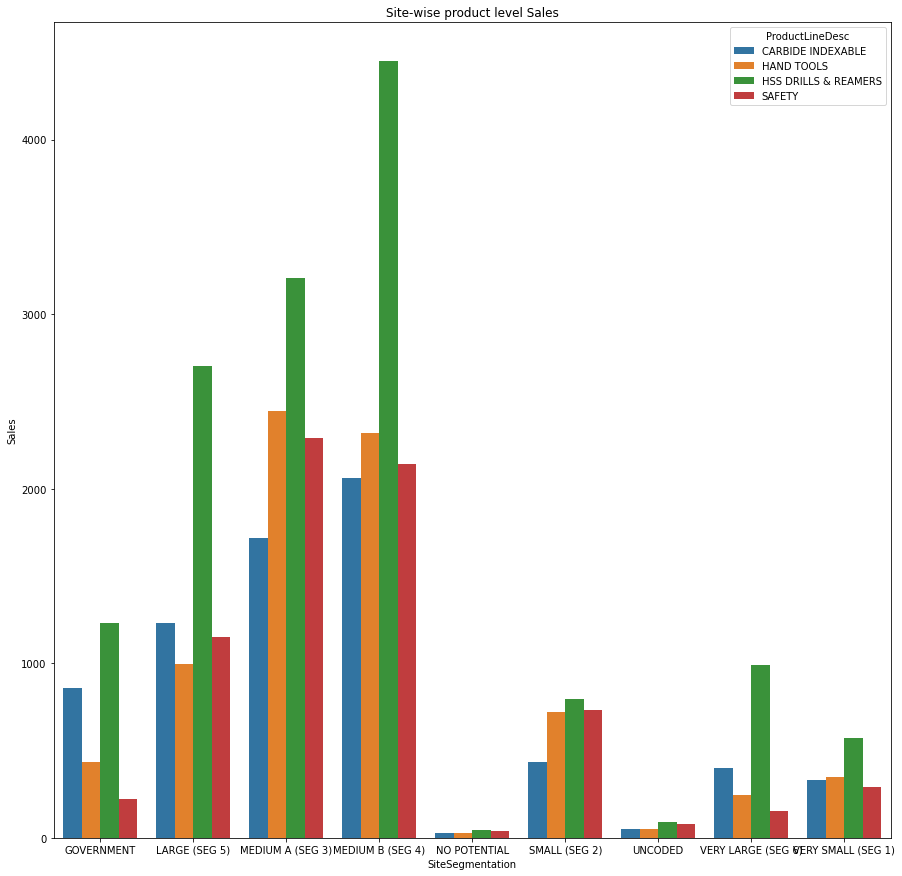

In [59]:
visual_df = df.groupby(['MSCFiscalYearMonth','ProductLineDesc','SiteSegmentation','ZoneDesc'], as_index=False).agg({"Sales": "count"})
import matplotlib.pyplot as plt
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x = "SiteSegmentation",
            y = "Sales",
            hue = "ProductLineDesc",
            data = visual_df,ci = None)
plt.title("Site-wise product level Sales")
plt.show()

# Plotting Months vs Sales vs Product Line

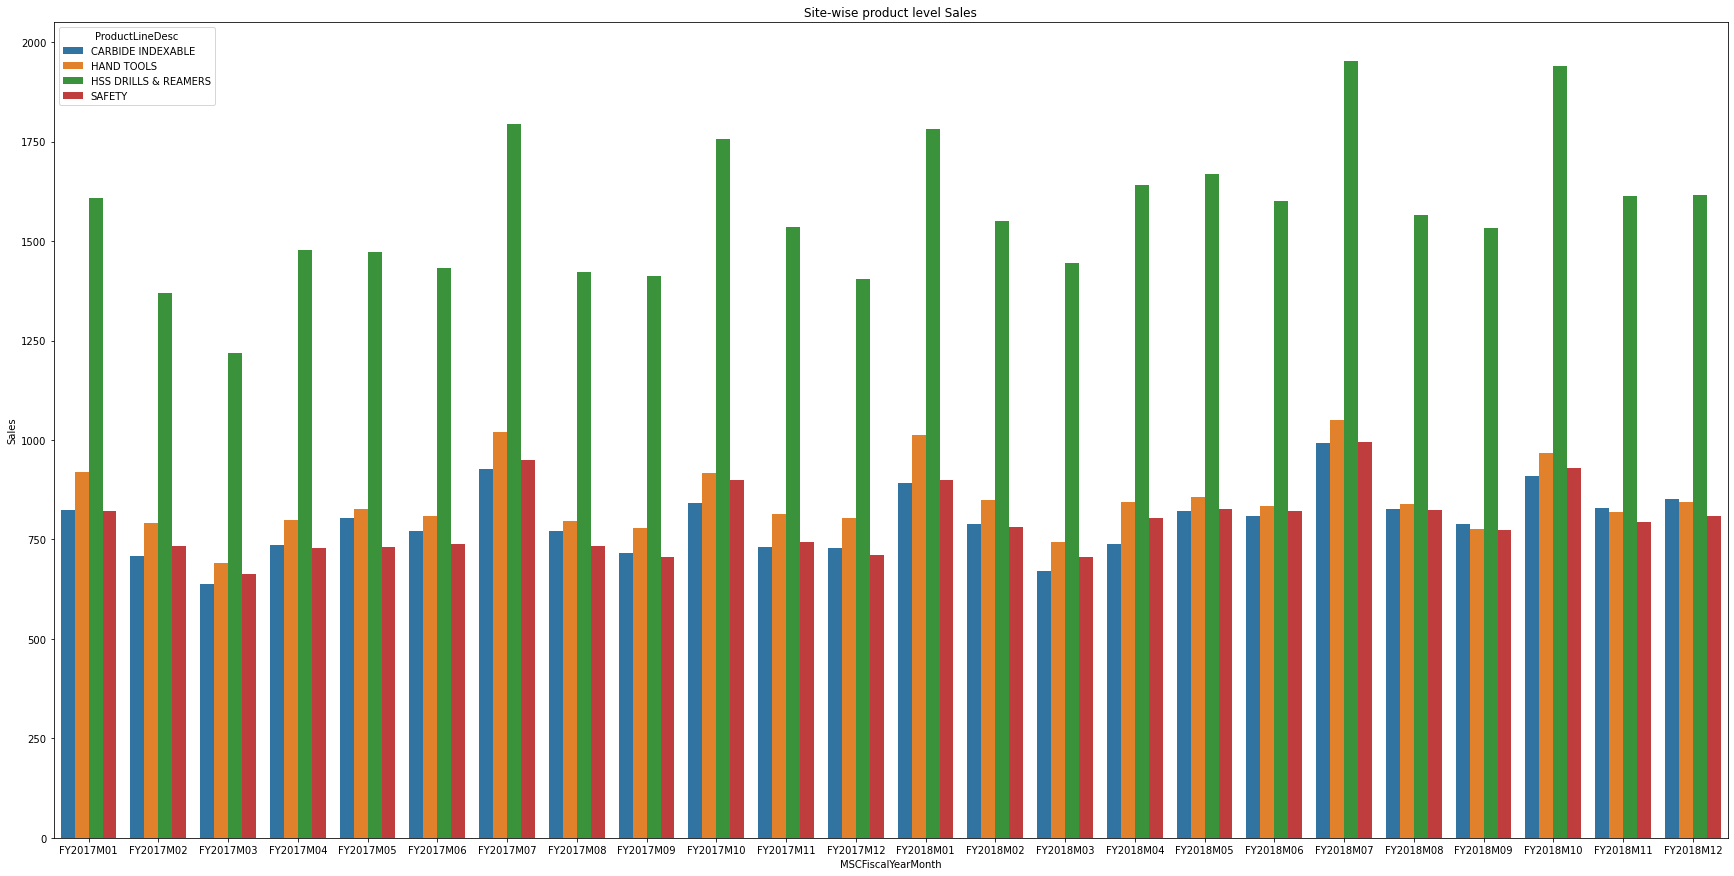

In [60]:
a4_dims = (30, 15)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x = "MSCFiscalYearMonth",
            y = "Sales",
            hue = "ProductLineDesc",
            data = visual_df,ci = None)
plt.title("Site-wise product level Sales")
plt.show()

# Plotting Zones vs Sales vs Product Line

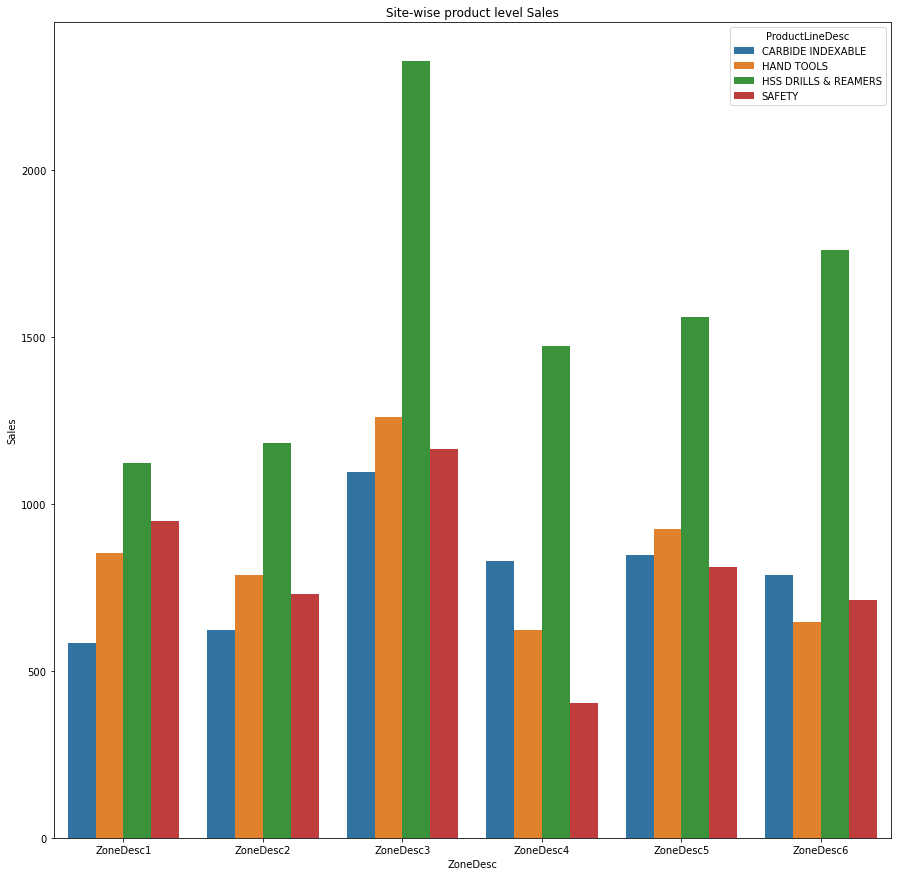

In [63]:
a4_dims = (15, 15)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(x = "ZoneDesc",
            y = "Sales",
            hue = "ProductLineDesc",
            data = visual_df,ci = None)
plt.title("Site-wise product level Sales")
plt.show()

# Creating temporary dataframe to train on the data which has information on years, quarters and product line

In [67]:
temp = df.groupby(['MSCFiscalYearMonth','ProductLineDesc'], as_index=False).agg({"Sales": "count"})
temp['YearMonth'] = df.MSCFiscalYearMonth.str[2:6] + "-"+df.MSCFiscalYearMonth.str[7:]
temp['Qtr'] = pd.to_datetime(temp.YearMonth).dt.quarter
temp['Year'] = temp.MSCFiscalYearMonth.str[2:6]
temp['Year'] = (temp['Year'].astype('int'))-2016
temp = temp.join(pd.get_dummies(temp["ProductLineDesc"]))
temp = temp.drop(columns = ["YearMonth","ProductLineDesc","MSCFiscalYearMonth"])
temp = temp.sort_values(by = ["Year","Qtr",])

# Scatter plot Quarters vs Sales

Text(0, 0.5, 'Sales')

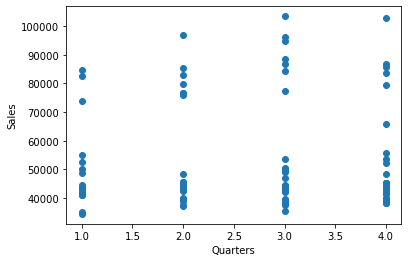

In [69]:
plt.scatter(temp["Qtr"],temp["Sales"])
plt.xlabel('Quarters')
plt.ylabel('Sales')

# Fitting model only on quarterly and yearly data to set a baseline

In [80]:
modelx = XGBRegressor()
X,y = temp.iloc[0:, 1:3], temp.iloc[0:, 0]
modelx.fit(X,y)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model2, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv)
scores = abs(scores)
print('Mean MAPE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAPE: 0.295 (0.037)


# Creating the training set and using XGBRegressor and RandomForestregressor to learn from the data and validating using 5 fold cross validation

In [81]:
X,y = temp.iloc[0:, 1:], temp.iloc[0:, 0]


In [82]:
model1 = XGBRegressor()
model1.fit(X, y)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model1, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv)
scores = abs(scores)
print('Mean MAPE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAPE: 0.095 (0.010)


In [83]:
model2 = RandomForestRegressor()
model2.fit(X, y)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(model2, X, y, scoring='neg_mean_absolute_percentage_error', cv=cv)
scores = abs(scores)
print('Mean MAPE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAPE: 0.089 (0.009)


# Creating a test set with data from next year for model to predict on and plotting the predictions against existing sales

In [84]:
test = temp.copy()
test["Year"] = test["Year"]*3
test = test.drop(range(48,96))
Sales_in_2017 = np.asarray(temp.iloc[0:48,0])
Sales_in_2018 = np.asarray(temp.iloc[48:,0])
Sales_in_2019 = np.asarray(model2.predict(temp.iloc[0:48, 1:]))
x_axis = np.arange(0,48)

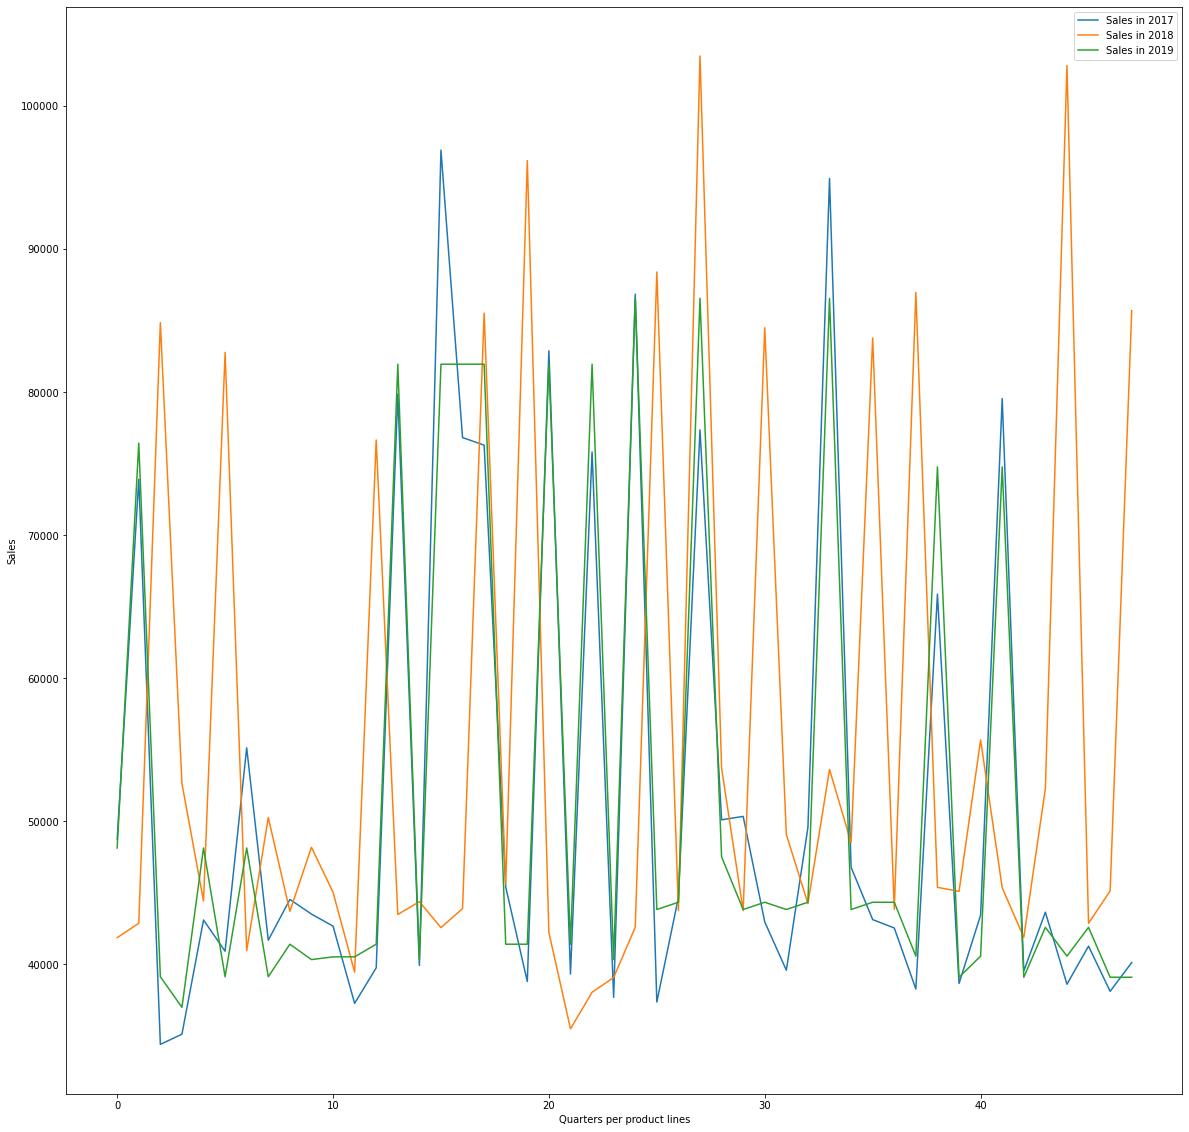

In [85]:
a4_dims = (20, 20)
fig, ax = plt.subplots(figsize=a4_dims)
plt.plot(x_axis,Sales_in_2017)
plt.plot(x_axis,Sales_in_2018)
plt.plot(x_axis,Sales_in_2019)
plt.xlabel('Quarters per product lines')
plt.ylabel('Sales')
plt.legend(["Sales in 2017", "Sales in 2018","Sales in 2019"])